1. [Libraries and Imports](#1)
2. [Statistics](#2)
3. [aa](#3)
4. [bb](#4)
5. [cc](#5)

<a id="1"></a>

### Libraries and Imports

In [12]:
# base 
import os 
import sys
from src import helpers, config, plotting, evaluation
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle
import logging
from pathlib import Path
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional, Iterable, Hashable, Type

# base
from sklearn.base import TransformerMixin

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# models
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')


# yet to arrange
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = config.DEFAULT_FIGSIZE
mpl.rcParams['lines.linewidth'] = config.DEFAULT_PLOT_LINEWIDTH
mpl.rcParams['lines.linestyle'] = config.DEFAULT_PLOT_LINESTYLE
mpl.rcParams['font.size'] = config.DEFAULT_AXIS_FONT_SIZE

# logging settings 
logging.basicConfig(level=logging.DEBUG, format='%(levelname)s:%(message)s')

In [9]:
# test
assert config.TRAIN_FILE_PATH == Path.cwd().parent / "data" / "final"
assert config.REPORTS_PATH == Path.cwd().parent / "reports" / "figures"
assert config.RAW_FILE_PATH == Path.cwd().parent / "data" / "raw"

In [43]:
# download and place data in the raw folder
raw_filename = 'Loan_Default.csv'
if os.path.exists(config.RAW_FILE_PATH / raw_filename): 
    print(f'READING FROM THE LOCAL COPY')
    df = pd.read_csv(config.RAW_FILE_PATH / raw_filename)
else: 
    print(f'FILE DOES NOT EXIST: {raw_filename}')
    print('DOWNLOADING DATA >>>')
    df = pd.read_csv('gs://aml_1/Loan_Default.csv')
    df.to_csv(config.RAW_FILE_PATH / raw_filename)
    df.head()

FILE DOES NOT EXIST: Loan_Default.csv
DOWNLOADING DATA >>>


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [ ]:
# # the iris dataset is used as a toy df 
# from sklearn.datasets import fetch_openml

# iris = fetch_openml(name="iris", version=1, as_frame=True)

# df = iris['data']
# df_target = iris['target']
# df = pd.concat([df, df_target], axis=1)
# type(df)

pandas.core.frame.DataFrame

In [44]:
df.columns = helpers.standardize_cols(df.columns)
df.columns

Index(['id', 'year', 'loan_limit', 'gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'credit_worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'interest_rate_spread', 'upfront_charges', 'term', 'neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'income', 'credit_type', 'credit_score', 'co_applicant_credit_type',
       'age', 'submission_of_application', 'ltv', 'region', 'security_type',
       'status', 'dtir1'],
      dtype='object')

In [ ]:
TARGET = 'class'

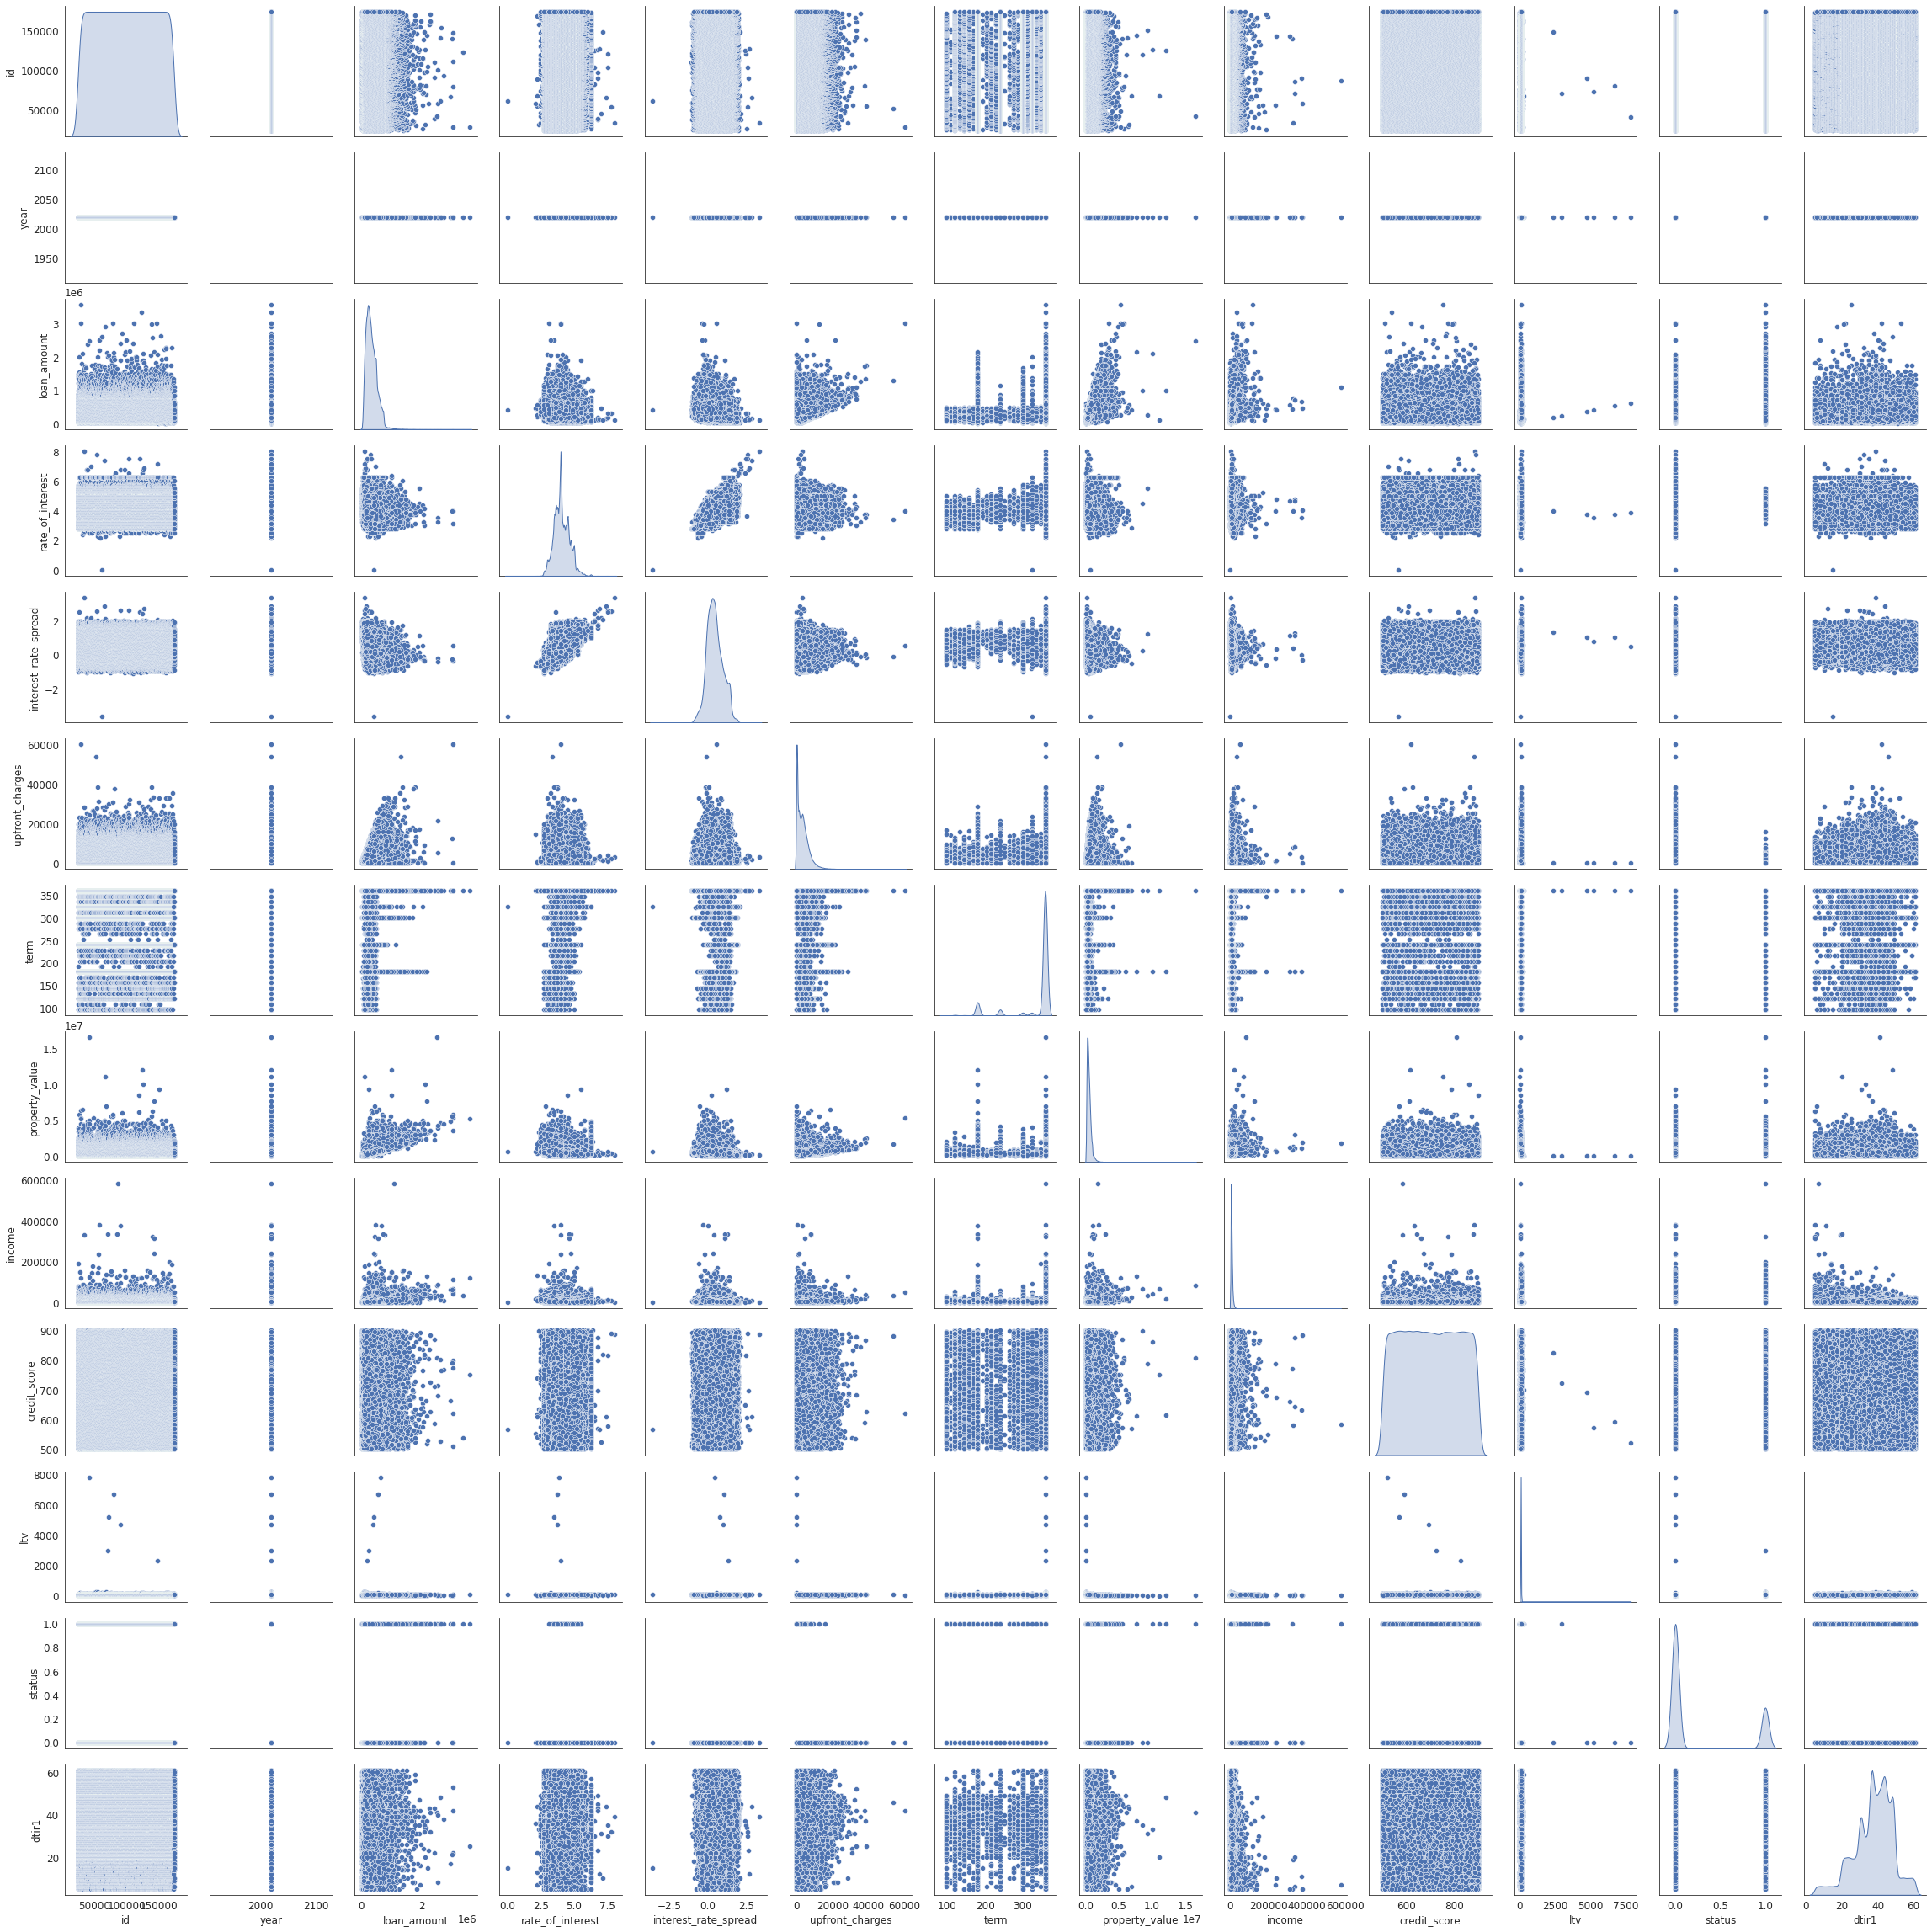

In [45]:
plotting.quick_plot(df)

<a id="2"></a>

### Statistics

In [ ]:
helpers.quick_eda(df)

DATAFRAME HAS 150 ROWS AND 5 COLS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sepallength  150 non-null    float64 
 1   sepalwidth   150 non-null    float64 
 2   petallength  150 non-null    float64 
 3   petalwidth   150 non-null    float64 
 4   class        150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB
None


,count,mean,std,min,25%,50%,75%,max
sepallength,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepalwidth,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petallength,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petalwidth,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Data preprocessing steps
- Creating - any features to engineer? 
- Correcting - any anomalies to correct? 
- Converting - any dtypes to correct? 
- Completing - any missing values to complete? 

### Completing

Get the numeric and categorical columns for preprocessing

NUMBER OF MISSING COLUMNS: 0
MISSING COLUMNS (0: NO MISSING VALUES, 1: MISSING VALUES
sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
class          0
dtype: int64


MISSINGNESS THROUGHOUT THE DATA


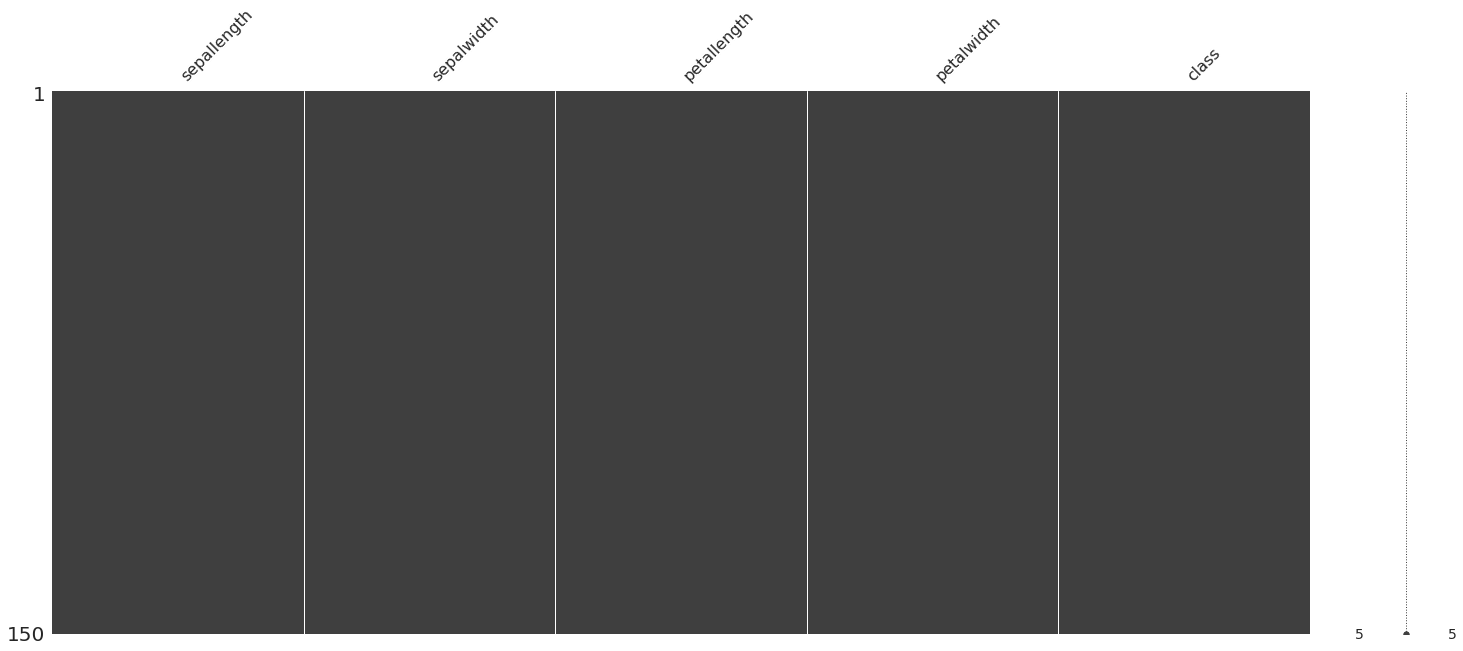

MISSINGNESS CORRELATIONS


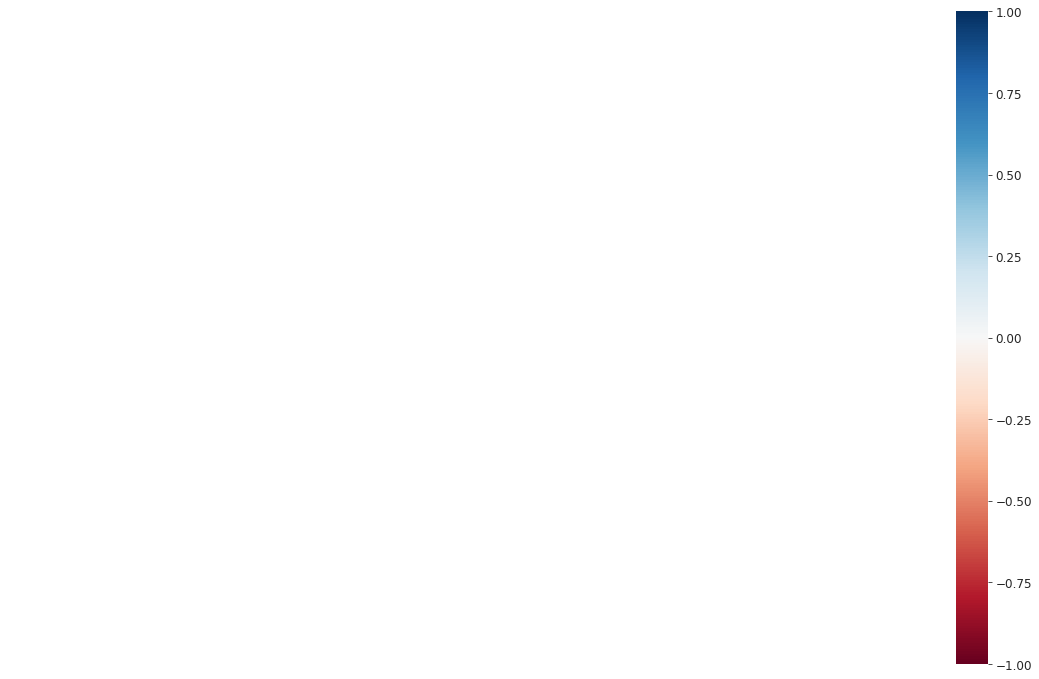

In [ ]:
helpers.missingness_checks(df)

In [ ]:
df_numeric = df[helpers.get_numeric_columns(df)]
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sepallength  150 non-null    float64
 1   sepalwidth   150 non-null    float64
 2   petallength  150 non-null    float64
 3   petalwidth   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [ ]:
df_categorical = df[helpers.get_categorical_columns(df)]
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   class   150 non-null    category
dtypes: category(1)
memory usage: 410.0 bytes


In [ ]:
helpers.get_dtypes(df)

{'sepallength': dtype('float64'),
 'sepalwidth': dtype('float64'),
 'petallength': dtype('float64'),
 'petalwidth': dtype('float64'),
 'class': CategoricalDtype(categories=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], ordered=False)}

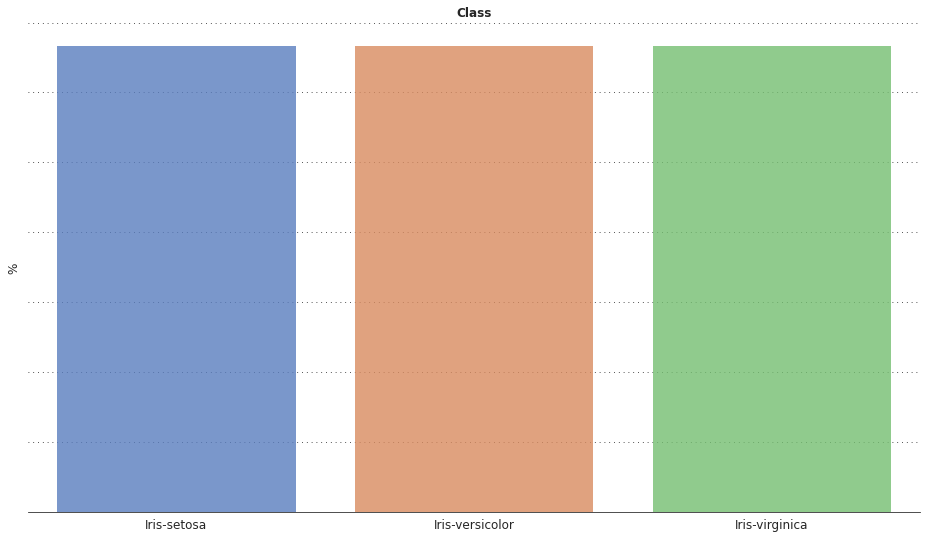

In [ ]:
petalwidth_plot = plotting.plotviz(df=df, figsize=(16, 9), rows=1, cols=1, X=['class'], y='petalwidth')
petalwidth_plot.bar()

### Note 

In [ ]:
# try to use type hinting where possible so as to prevent unintended behaviour
# Example function 
def double(n: str) -> str: 
    '''
    docstrings here: follow the numpy format
    '''
    return n*2 

In [ ]:
## helper functions to add on - preprocessing 

def drop_duplicate_cols(df: pd.DataFrame, cols: Hashable) -> pd.DataFrame: 
    pass  


def check_columns(): pass

## helper functions to add on - visualization

### Correlations

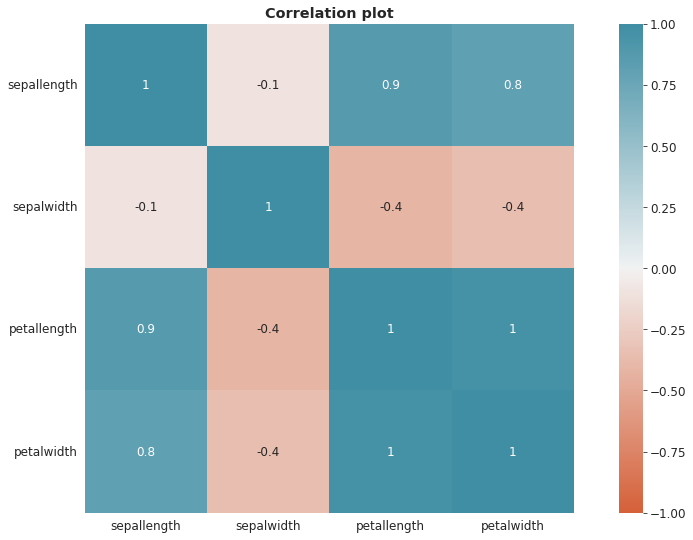

In [ ]:
### Corr
plotting.plot_corr(df, rotate_xlabels=False)

### Preprocessing stuff

In [ ]:
# enc = LabelEncoder()
# df['class_enc'] = enc.fit_transform(df['class'])
# df['class_enc']

In [ ]:
# make dummies 
# category_enc = pd.get_dummies(df['class'], drop_first=True)
# category_enc


# removing outliers

# std = df['petallength'].std()
# mean = df['petallength'].mean() 
# cutoff = std * 3
# lower, upper = mean - cutoff, mean + cutoff

# df_trim = df[(df['petallength'] < upper) & (df['petallength'] > lower)]


# scaling data 
# SS = StandardScaler() 
# df['petallength_ss'] = SS.fit_transform(df[['petallength']])



In [ ]:
num_cols = helpers.get_numeric_columns(df)

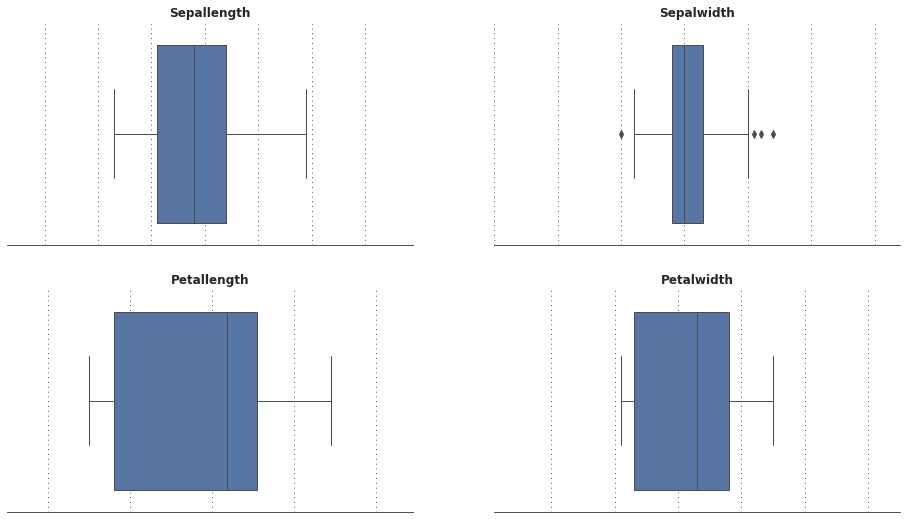

In [ ]:
boxp = plotting.plotviz(df=df[num_cols], X=num_cols, cols=2, rows=2)
boxp.box()

### Train test split

In [ ]:
df = df[['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class']].sample(frac=1).reset_index(drop=True)

X = df.drop(columns=TARGET)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config.RANDOM_STATE)

### Hyperparameter tuning

### Randomized search

In [ ]:
def evaluate_tuning_results(tuner: Union[Type[RandomizedSearchCV], Type[GridSearchCV]]) -> None: 
    print(
    f'''
    TUNING RESULTS
    ####################################
    ESTIMATOR: {tuner.estimator}
    BEST SCORE: {tuner.best_score_:.2%}
    BEST PARAMS: {tuner.best_params_}
    AVERAGE TRAIN SCORE: {tuner.cv_results_["mean_train_score"].mean():.2%}
    AVERAGE TRAIN SD: {tuner.cv_results_["std_train_score"].mean():.2%}
    AVERAGE TEST SCORE: {tuner.cv_results_["mean_test_score"].mean():.2%}
    AVERAGE TEST SD: {tuner.cv_results_["std_test_score"].mean():.2%}
    ''')

def evaluate_report(y_test: pd.Series, y_pred: np.ndarray) -> None: 
    print(
    f'''
    PERFORMANCE 
    ####################################
    ACCURACY: {accuracy_score(y_test, y_pred):.2%}
    PRECISION: {precision_score(y_test, y_pred):.2%}
    RECALL: {recall_score(y_test, y_pred):.2%}
    F1: {f1_score(y_test, y_pred):.2%}
    ROC AUC: {roc_auc_score(y_test, y_pred):.2%}
    ''')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# create param
param_grid = {'max_depth': np.arange(2, 10, 2),
              'max_features': np.arange(1, 3),
              'min_samples_split': np.arange(2, 12, 2)}

# create a scorer
scorer = make_scorer(accuracy_score)

random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, 
                   n_iter=10, cv=5, scoring=scorer, refit=True, return_train_score=True)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([2, 4, 6, 8]),
                                        'max_features': array([1, 2]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10])},
                   return_train_score=True,
                   scoring=make_scorer(accuracy_score))

In [ ]:
evaluation.evaluate_tuning_results(random_search)

TUNING RESULTS
####################################
ESTIMATOR: RandomForestClassifier()
BEST SCORE: 96.67%
BEST PARAMS: {'min_samples_split': 10, 'max_features': 2, 'max_depth': 4}
AVERAGE TRAIN SCORE: 97.73%
AVERAGE TRAIN SD: 0.90%
AVERAGE TEST SCORE: 95.58%
AVERAGE TEST SD: 3.87%


In [ ]:
print(f'Parameters for {random_search.estimator}:\n{random_search.get_params()}')
print(f'Parameters to tune: {random_search.param_distributions}')

Parameters for RandomForestClassifier():
{'cv': 5, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(), 'n_iter': 10, 'n_jobs': None, 'param_distributions': {'max_depth': [2, 4, 6, 8], 'max_features': [1, 2], 'min_samples_split': [2, 4, 6, 8, 10]}, 'pre_dispatch': '2*n_jobs', 'random_state': None, 'refit': True, 'return_train_score': True, 'scoring': make_scorer(

In [ ]:
## Fit model 
rf_best = random_search.best_estimator_
rf_best.fit(X_train, y_train)

# pd.Series(rf_best.predict(X_test)).value_counts()

RandomForestClassifier(max_depth=4, max_features=2, min_samples_split=10)

In [ ]:
type(y_test)

pandas.core.series.Series

In [ ]:
print(f"ACCURACY: {accuracy_score(y_test, rf_best.predict(X_test)):.2%}")
confusion_matrix(y_test, rf_best.predict(X_test))

ACCURACY: 96.67%


array([[ 8,  0,  0],
       [ 0,  9,  1],
       [ 0,  0, 12]])

In [ ]:
filename = config.MODEL_OUTPUT_PATH / 'model.pickle'
with open(filename, 'wb')  as file:
    pickle.dump(rf_best, file)

In [ ]:
# Reload the model 
with open(filename, 'rb')  as file:
    model = pickle.load(file)

# use loaded pickle
model.predict(X_test)

array(['Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica',
       'Iris-setosa', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor'], dtype=object)

### Grid search 

In [ ]:
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid, 
                           scoring=scorer, n_jobs=config.N_JOBS, 
                           cv=5, refit=True, 
                           return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([2, 4, 6, 8]),
                         'max_features': array([1, 2]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10])},
             return_train_score=True, scoring=make_scorer(accuracy_score))

In [ ]:
evaluation.evaluate_tuning_results(grid_search)

TUNING RESULTS
####################################
ESTIMATOR: RandomForestClassifier()
BEST SCORE: 97.50%
BEST PARAMS: {'max_depth': 2, 'max_features': 2, 'min_samples_split': 8}
AVERAGE TRAIN SCORE: 98.09%
AVERAGE TRAIN SD: 0.76%
AVERAGE TEST SCORE: 96.06%
AVERAGE TEST SD: 3.52%


### Logistic Regression (OVR)

In [ ]:
# the iris dataset is used as a toy df 
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)

bs = boston['data']
bs_target = boston['target']
bs = pd.concat([bs, bs_target], axis=1)
type(df)

pandas.core.frame.DataFrame

In [ ]:
ovr = OneVsRestClassifier(LogisticRegression())

In [ ]:
# LogisticRegression().get_params()

In [ ]:
lr_param_grid = {
    'C': 1.0,
    'class_weight': None,
    'dual': False,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'l1_ratio': None,
    'max_iter': 100,
    'multi_class': 'auto',
    'n_jobs': None,
    'random_state': None,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'tol': 0.0001}

### SVCs

In [ ]:
svc = SVC()

In [ ]:
# svc.get_params()

svc_param_grid = {
    'C': 1.0,
    'break_ties': False,
    'cache_size': 200,
    'class_weight': None,
    'coef0': 0.0,
    'decision_function_shape': 'ovr',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'max_iter': -1,
    'probability': False,
    'random_state': None,
    'shrinking': True,
    'tol': 0.001,
    'verbose': False}

### Pipelines

In [ ]:
# ultimately, we do want to be making a pipeline 
pp = Pipeline([
        ('ohe', OneHotEncoder()),
        ('le', LabelEncoder()), 
        ('mm', MinMaxScaler()),
        ('clf', OneVsRestClassifier(SVC()))
     ])
# feature union - independently transform features and concat them together
pp_with_feat_union = Pipeline([
        ('features',
        FeatureUnion([
        ('ohe', OneHotEncoder()),
        ('le', LabelEncoder()), 
        ('mm', MinMaxScaler()) 
        ])),
        ('clf', OneVsRestClassifier(SVC()))
     ])

# column 
col_trans = ColumnTransformer([
        ('cat', OneHotEncoder(), ['AGE', 'DIS']),
        ('text', CountVectorizer(), 'CHAS')
    ],
    remainder='drop')

pp_cols = Pipeline([
    ('cols', col_trans),
    ('clf', OneVsRestClassifier(SVC()))
])

In [ ]:
# basic custom transformers for pipelining
class ExtractYear(TransformerMixin): 

    def __init__(self) -> None: 
        pass 

    def fit(self): 
        return self
    
    def transform(self, X: Union[pd.DataFrame, pd.Series]): 
        if isinstance(X, pd.DataFrame): 
            pass
        if isinstance(X, pd.Series): 
            pass

In [ ]:
## Visualising pielines
display(pp_with_feat_union)
display(pp)
display(pp_cols)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ohe', OneHotEncoder()),
                                                ('le', LabelEncoder()),
                                                ('mm', MinMaxScaler())])),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

Pipeline(steps=[('ohe', OneHotEncoder()), ('le', LabelEncoder()),
                ('mm', MinMaxScaler()),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

Pipeline(steps=[('cols',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['AGE', 'DIS']),
                                                 ('text', CountVectorizer(),
                                                  'CHAS')])),
                ('clf', OneVsRestClassifier(estimator=SVC()))])

### XGB

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
# create DMatrix from train and test sets: optimized for memory efficiency 
def convert_to_dmatrix(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> Tuple[xgb.DMatrix]: 
    # doesn't work on non-numeric columns 
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    return dtrain, dtest

In [ ]:
dtrain, dtest = convert_to_dmatrix(X_train, X_test, y_train, y_test)

ValueError: Cannot cast object dtype to float64

In [ ]:
# gbm example
xgb_gbm = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', 
                            n_jobs=config.N_JOBS, random_state=config.RANDOM_STATE, verbosity=0)

In [ ]:
# function for plotting feature importances
def plot_feature_importances(booster, figsize: Tuple[int] = config.DEFAULT_FIGSIZE) -> None: 
    fig, ax = set_up_fig(nrows=1, ncols=1, figsize=figsize)

    for s in ('top', 'left', 'right'):
        ax.spines[s].set_visible(False)
    
    xgb.plot_importance(booster=booster, ax=ax, grid=False)
    plt.show()